# Imports

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
# #os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# #use another GPU if the default one is occupied
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#import utils from the parent folder
import sys
sys.path.append('../')

In [4]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

import pickle

########## IMPORT JAX ECOSYSTEM ##########
import jax
import jax.numpy as np
from jax.random import split, PRNGKey

jax.config.update('jax_debug_nans', True)

import optax
import equinox as eqx

import jax_md
import jax_md.dataclasses as jdc

########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.simulation import simulation, sim_trajectory
from jax_morph.optimization.losses import loss

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate


########## IMPORT PLOTTING UTILITIES ##########
###############################################
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})


########## IMPORT OTHER UTILITIES ##########
############################################
from tqdm import tqdm, trange
from functools import partial
from collections import namedtuple

from alife_utils import default_params, build_sim_from_params, run_optimization

# Set Parameters

In [5]:
key = PRNGKey(0)


key, init_key = split(key)
Dparams, Dtrain_params = default_params(init_key)
Dparams['ncells_add'] = 119
Dparams['hidden_state_size'] = 64

In [6]:
key, subkey = split(key)
sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

In [16]:
def position_sum_of_squares(state):

    alive = state.celltype > 0
    
    n = np.sum(alive)

    m = np.abs(np.sum((state.position[:, 1] * alive)**2)/n - 3) #- np.sum((state.position[:, 0] * alive)**2)

    m += .1*np.sum(np.abs(state.position[:, 0] * alive))/n

    #m = m / np.sum(alive)

    return m

## One optimization

Random hempirical facts:
- averaging over more than 8 or 16 simulation seems to impaire learning (?)

In [17]:
EPOCHS = 500
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64

LEARNING_RATE = 5e-4
#LEARNING_RATE = optax.piecewise_constant_schedule(1e-3, {200: .1})

METRIC_FN = position_sum_of_squares

SAVE_EVERY = 100

key, train_key = split(key)
loss_t, params_t, _ = run_optimization(train_key,
                                       sim,
                                       METRIC_FN,
                                       metric_type='cost',
                                       epochs=EPOCHS,
                                       episodes_per_update=EPISODES_PER_UPDATE,
                                       episodes_per_eval=EPISODES_PER_EVAL,
                                       learning_rate=LEARNING_RATE,
                                       save_every=SAVE_EVERY
                                       )


Loss: 3.9102: 100%|███████████████████████████| 500/500 [09:26<00:00,  1.13s/it]


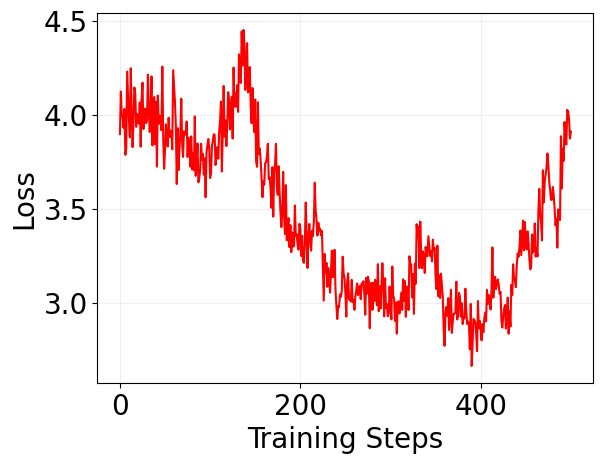

In [18]:
plt.plot(loss_t, 'r')

plt.grid(alpha=.2)

plt.xlabel('Training Steps')
plt.ylabel('Loss');

In [124]:
# Log = namedtuple('Log', ['loss_t', 'params_t', 'init_params', 'train_params', 'save_every', 'epochs', 'episodes_per_update', 'episodes_per_eval', 'learning_rate'])

# with open('log_opt_elongation.pkl', 'wb') as f:
#     pickle.dump(Log(loss_t, params_t, sim.params, sim.train_params, SAVE_EVERY, EPOCHS, EPISODES_PER_UPDATE, EPISODES_PER_EVAL, LEARNING_RATE), f)

# Tests

In [13]:
LogExperiment = namedtuple('LogExperiment', ['epochs', 'episodes_per_update', 'episodes_per_eval', 'learning_rate', 'sim', 'opt_runs'])

LogRep = namedtuple('LogRep', ['loss_t', 'params_t', 'grads_t'])


N_OPT = 5

EPOCHS = 50
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 100

LEARNING_RATE = 1e-3

METRIC_FN = position_sum_of_squares


log = LogExperiment(epochs=EPOCHS, 
                    episodes_per_update=EPISODES_PER_UPDATE, 
                    episodes_per_eval=EPISODES_PER_EVAL, 
                    learning_rate=LEARNING_RATE, 
                    sim=sim, 
                    opt_runs=[]
                    )

for i in range(N_OPT):

    key, train_key = split(key)
    loss_t, params_t, _ = run_optimization(train_key,
                                            sim,
                                            METRIC_FN,
                                            metric_type='cost',
                                            epochs=EPOCHS,
                                            episodes_per_update=EPISODES_PER_UPDATE,
                                            episodes_per_eval=EPISODES_PER_EVAL,
                                            learning_rate=LEARNING_RATE,
                                            )

    log.opt_runs.append(LogRep(loss_t=loss_t, params_t=params_t, grads_t=None))


# with open('log_opt_reps.pkl', 'wb') as f:
#     pickle.dump(log, f)

Loss: 8.0468: 100%|█████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


In [ ]:
for i in log:
    plt.plot(log[i]['loss'], 'r', alpha=.3)

plt.grid(alpha=.2)

plt.xlabel('Training Steps')
plt.ylabel('Loss');

In [14]:
LogExperiment = namedtuple('LogExperiment', ['epochs', 'episodes_per_update', 'episodes_per_eval', 'learning_rate', 'sim', 'opt_runs'])

LogRep = namedtuple('LogRep', ['loss_t', 'params_t', 'grads_t'])


EPOCHS = 50
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 100

LEARNING_RATE = 1e-3

METRIC_FN = position_sum_of_squares


SAVE_EVERY = 100

log = LogExperiment(epochs=EPOCHS, 
                episodes_per_update=EPISODES_PER_UPDATE, 
                episodes_per_eval=EPISODES_PER_EVAL, 
                learning_rate=LEARNING_RATE, 
                sim=sim, 
                opt_runs={}
                )



n_chem = [1, 2, 3, 5, 10]

for N_CHEM in n_chem:

    Dparams, Dtrain_params = default_params(init_key, N_CHEM)
    Dparams['ncells_add'] = 119

    key, subkey = split(key)
    sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

    key, train_key = split(key)
    loss_t, params_t, _ = run_optimization(train_key,
                                            sim,
                                            METRIC_FN,
                                            metric_type='cost',
                                            epochs=EPOCHS,
                                            episodes_per_update=EPISODES_PER_UPDATE,
                                            episodes_per_eval=EPISODES_PER_EVAL,
                                            learning_rate=LEARNING_RATE,
                                            save_every=SAVE_EVERY
                                            )

    log.opt_runs[N_CHEM] = LogRep(loss_t=loss_t, params_t=params_t, grads_t=None)


# with open('log_opt_reps.pkl', 'wb') as f:
#     pickle.dump(log, f)

Loss: 1.7341: 100%|█████████████████████████████| 50/50 [01:57<00:00,  2.36s/it]


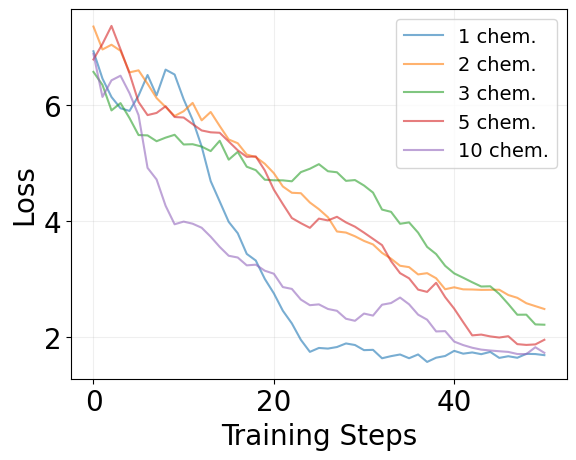

In [18]:
for nchem in sorted(log.opt_runs.keys()):
    plt.plot(log.opt_runs[nchem].loss_t, alpha=.6, label=f'{nchem} chem.')

plt.grid(alpha=.2)

plt.xlabel('Training Steps')
plt.ylabel('Loss');

plt.legend(fontsize=14);

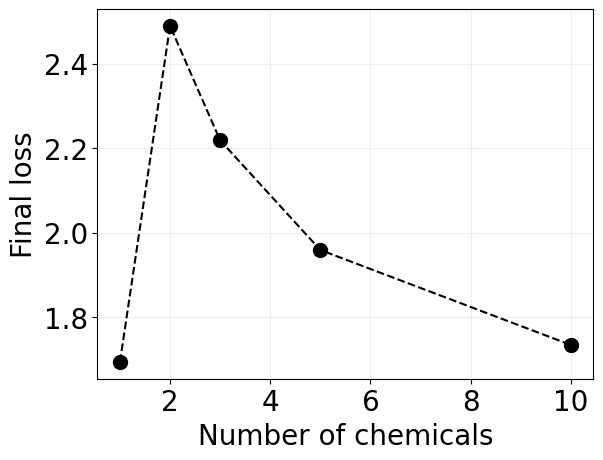

In [20]:
nchem = sorted(log.opt_runs.keys())
flooses = [log.opt_runs[nc].loss_t[-1] for nc in nchem]

plt.plot(nchem, flooses, 'o--', color='r', markersize=10)

plt.grid(alpha=.2)

plt.xlabel('Number of chemicals')
plt.ylabel('Final loss');

In [7]:
LogExperiment = namedtuple('LogExperiment', ['epochs', 'episodes_per_update', 'episodes_per_eval', 'learning_rate', 'sim', 'opt_runs'])

LogRep = namedtuple('LogRep', ['loss_t', 'params_t', 'grads_t'])


EPOCHS = 50
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 100

LEARNING_RATE = 1e-3

METRIC_FN = position_sum_of_squares


SAVE_EVERY = 100

log2 = LogExperiment(epochs=EPOCHS, 
                episodes_per_update=EPISODES_PER_UPDATE, 
                episodes_per_eval=EPISODES_PER_EVAL, 
                learning_rate=LEARNING_RATE, 
                sim=sim, 
                opt_runs={}
                )



hsize = [4, 8, 16, 32, 64]

for HID_SIZE in hsize:

    Dparams['hidden_state_size'] = HID_SIZE
    Dparams['ncells_add'] = 119


    key, subkey = split(key)
    sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

    key, train_key = split(key)
    loss_t, params_t, _ = run_optimization(train_key,
                                            sim,
                                            METRIC_FN,
                                            metric_type='cost',
                                            epochs=EPOCHS,
                                            episodes_per_update=EPISODES_PER_UPDATE,
                                            episodes_per_eval=EPISODES_PER_EVAL,
                                            learning_rate=LEARNING_RATE,
                                            save_every=SAVE_EVERY
                                            )

    log2.opt_runs[HID_SIZE] = LogRep(loss_t=loss_t, params_t=params_t, grads_t=None)

Loss: 3.2314: 100%|█████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


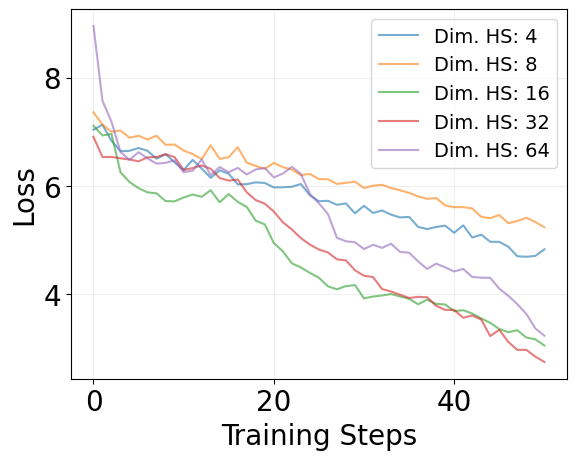

In [8]:
for hsize in sorted(log2.opt_runs.keys()):
    plt.plot(log2.opt_runs[hsize].loss_t, alpha=.6, label=f'Dim. HS: {hsize}')

plt.grid(alpha=.2)

plt.xlabel('Training Steps')
plt.ylabel('Loss');

plt.legend(fontsize=14);

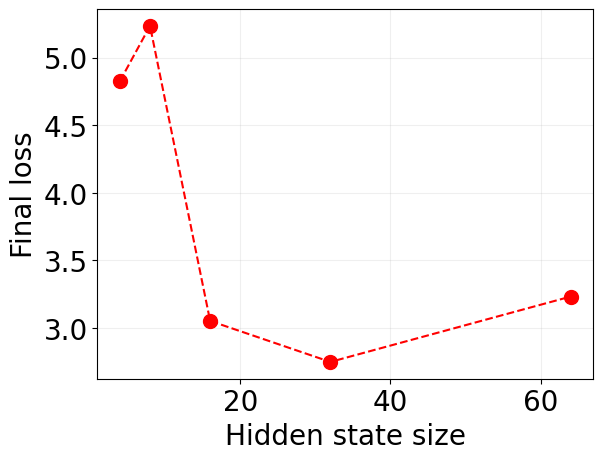

In [10]:
hsize = sorted(log2.opt_runs.keys())
flooses = [log2.opt_runs[hs].loss_t[-1] for hs in hsize]

plt.plot(hsize, flooses, 'o--', color='r', markersize=10)

plt.grid(alpha=.2)

plt.xlabel('Hidden state size')
plt.ylabel('Final loss');

# Analyze final states

## Initial params

In [11]:
NCELLS_ADD = sim.params['ncells_add']

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(sim.fstep, sim.params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)

print(METRIC_FN(fstate))

6.5909996


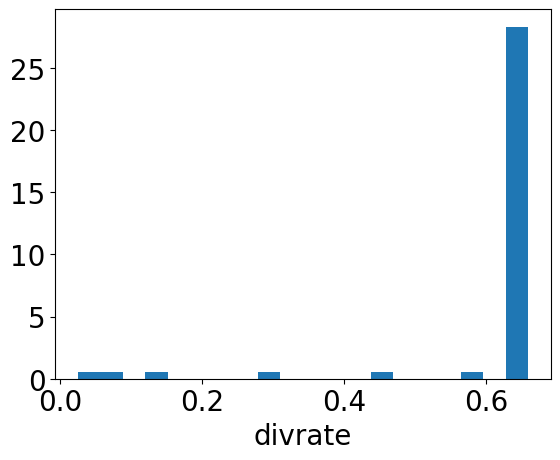

In [12]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

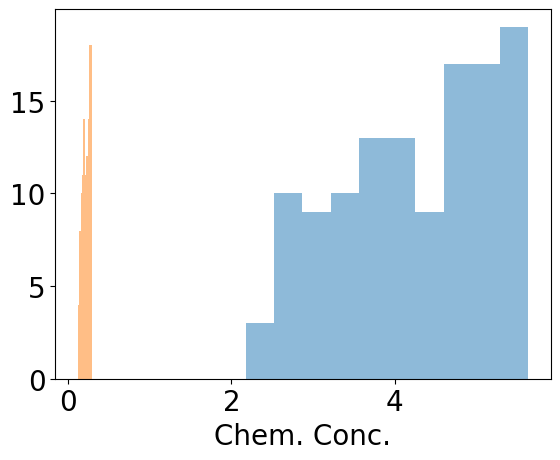

In [13]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

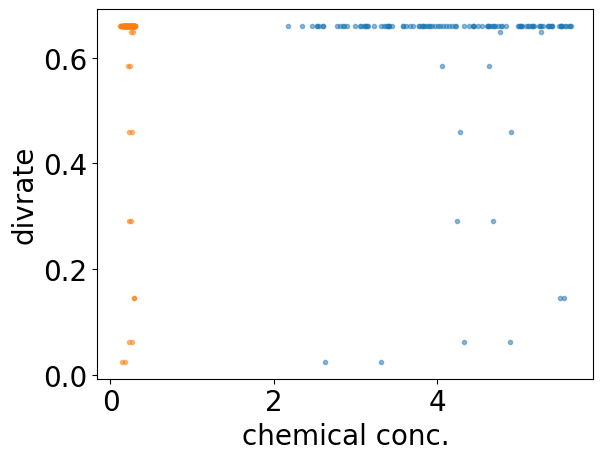

In [14]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

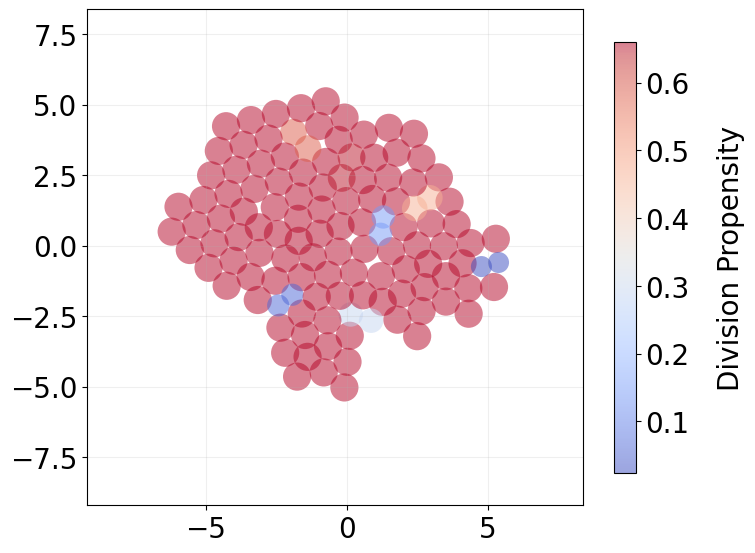

In [15]:
draw_circles_divrate(fstate, grid=True);

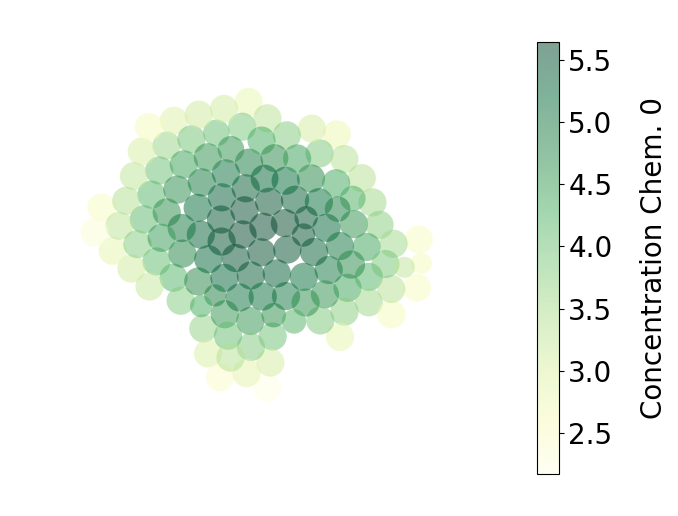

In [16]:
draw_circles_chem(fstate);

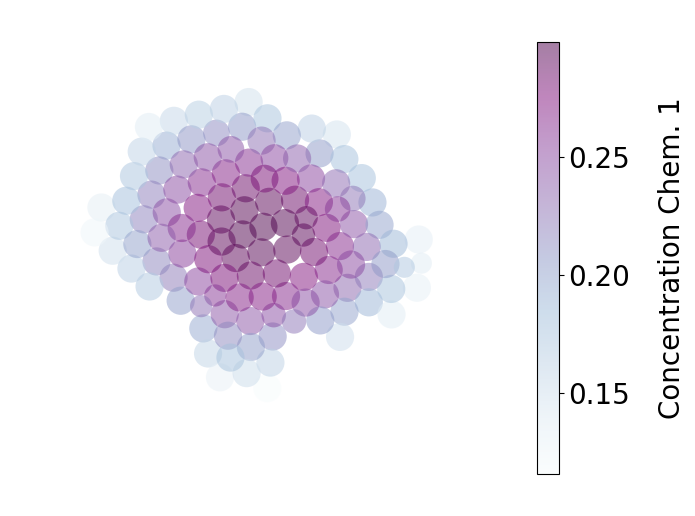

In [17]:
draw_circles_chem(fstate,1);

## Trained params

In [24]:
# merge params dicts
all_params = eqx.combine(params_t[-2], sim.params)

NCELLS_ADD = sim.params['ncells_add']

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(sim.fstep, all_params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(fstate)))

Final state metric:	2.5596778


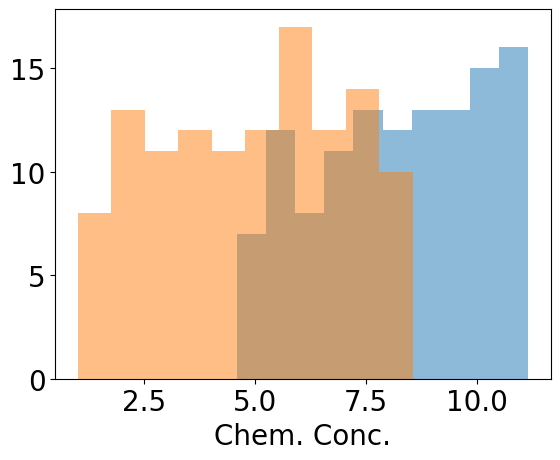

In [25]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

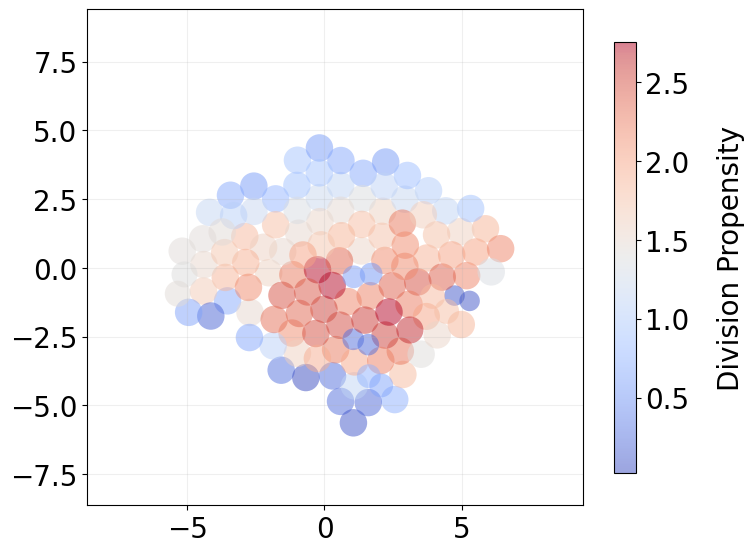

In [26]:
draw_circles_divrate(fstate, grid=True);

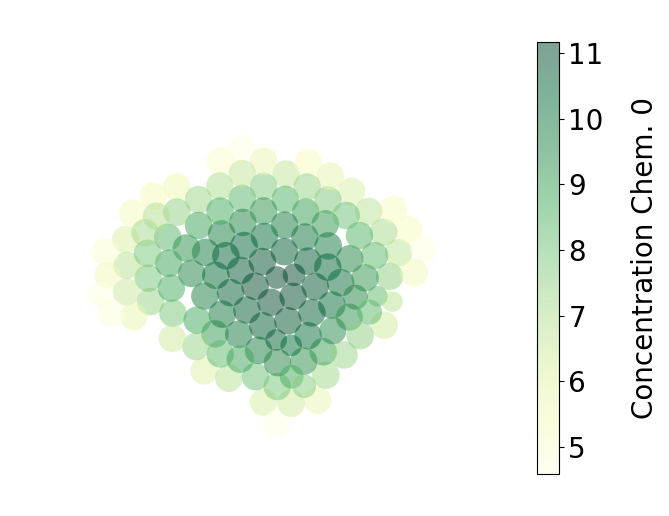

In [27]:
draw_circles_chem(fstate);

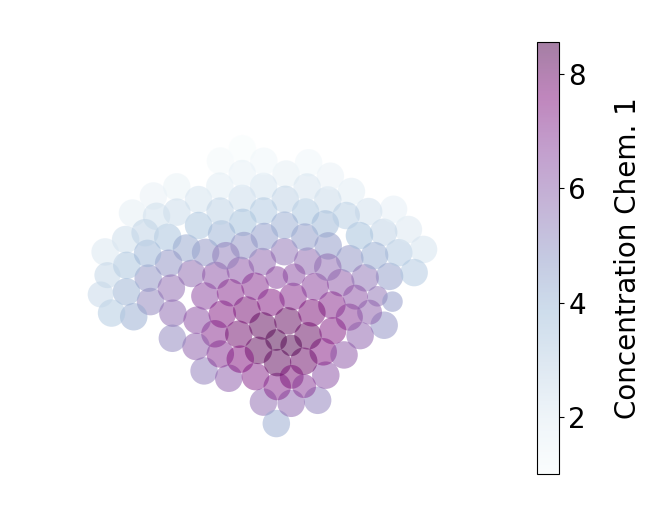

In [28]:
draw_circles_chem(fstate,1);

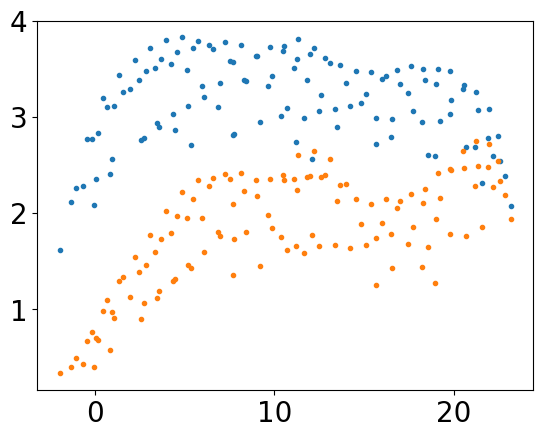

In [108]:
#smax = params_t[-1]['sec_max']
smax = sim.params['sec_max']

for i, c in enumerate(fstate.chemical.T):
    plt.plot(fstate.position[:,0], c/smax[i], '.')

# plt.plot(fstate.position[:,0], fstate.chemical[:,0]/smax[0], '.')
# plt.plot(fstate.position[:,0], fstate.chemical[:,1]/smax[1], '.')
# plt.plot(fstate.position[:,0], fstate.chemical[:,2]/smax[2], '.')

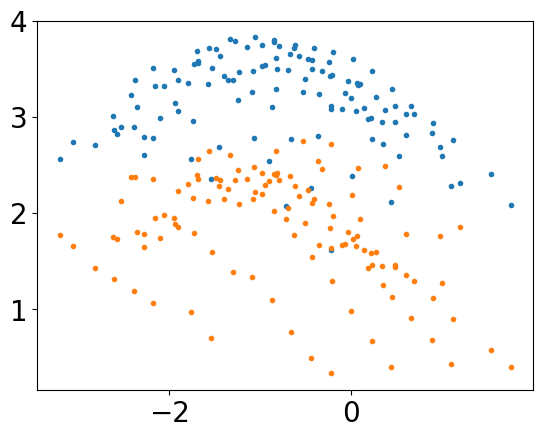

In [109]:
#smax = params_t[-1]['sec_max']
smax = sim.params['sec_max']

for i, c in enumerate(fstate.chemical.T):
    plt.plot(fstate.position[:,1], c/smax[i], '.')

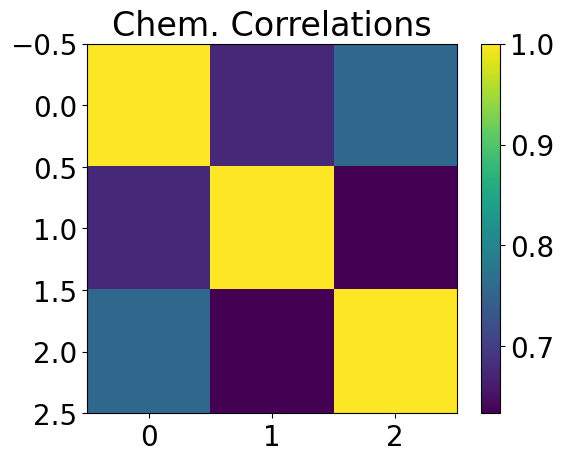

In [38]:
plt.imshow(np.corrcoef(fstate.chemical.T))
plt.colorbar();

plt.title('Chem. Correlations');

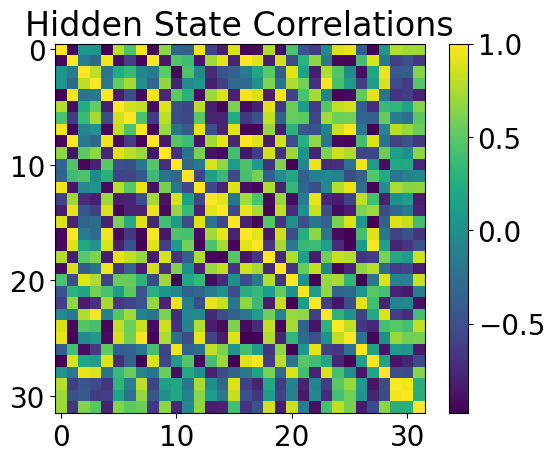

In [39]:
plt.imshow(np.corrcoef(fstate.hidden_state.T))
plt.colorbar();

plt.title('Hidden State Correlations');

In [36]:
#transform hidden states with pca to 2d
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# pca_hidden = pca.fit_transform(np.log(fstate.hidden_state + 1e-40))
pca_hidden = pca.fit_transform(fstate.hidden_state)


plt.scatter(pca_hidden[:,0], pca_hidden[:,1], c=fstate.divrate, cmap='coolwarm', alpha=.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.colorbar(label='Div. Propensity');

ModuleNotFoundError: No module named 'sklearn'

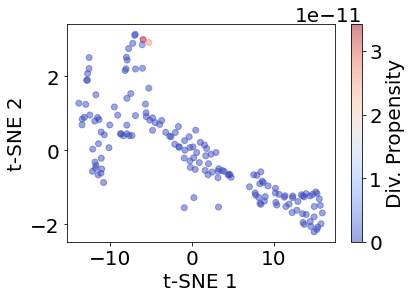

In [129]:
#transform hidden states with t-sne to 2d
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

# tsne_hidden = tsne.fit_transform(np.log(fstate.hidden_state + 1e-40))
tsne_hidden = tsne.fit_transform(fstate.hidden_state)


plt.scatter(tsne_hidden[:,0], tsne_hidden[:,1], c=fstate.divrate, cmap='coolwarm', alpha=.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.colorbar(label='Div. Propensity');


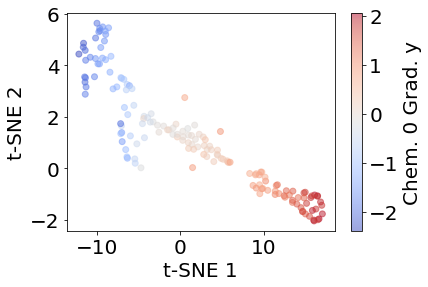

In [130]:
#transform hidden states with t-sne to 2d
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

# tsne_hidden = tsne.fit_transform(np.log(fstate.hidden_state + 1e-40))
tsne_hidden = tsne.fit_transform(fstate.hidden_state)


plt.scatter(tsne_hidden[:,0], tsne_hidden[:,1], c=fstate.chemgrad[:,7], cmap='coolwarm', alpha=.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.colorbar(label='Chem. 0 Grad. y');


# Regeneration

## Kill functions


In [120]:
def kill_random(key, state, kill_rate=.3):
    '''Kill cells randomly'''

    ncells = int((state.celltype > 0).sum())
    nkill = int(ncells * kill_rate)

    #randomly select cells to kill
    kill_idx = jax.random.choice(key, ncells, shape=(nkill,), replace=False)

    #get only cells not in kill_idx
    new_fields = {}
    for field in jdc.fields(state):

        value = getattr(state, field.name)

        if 'key' == field.name:
            new_fields[field.name] = state.key
        else:
            new_fields[field.name] = np.delete(value, kill_idx, axis=0)


    state = type(state)(**new_fields)

    return state


def kill_line(state, m=10, b=0):
    '''Kill cells below line y=mx+b'''

    alive = state.celltype > 0
    pos = state.position[alive]

    #select cells to kill
    kill_idx = np.argwhere(pos[:,1] < m*pos[:,0] + b).flatten()

    #get only cells not in kill_idx
    new_fields = {}
    for field in jdc.fields(state):

        value = getattr(state, field.name)

        if 'key' == field.name:
            new_fields[field.name] = state.key
        else:
            new_fields[field.name] = np.delete(value, kill_idx, axis=0)


    state = type(state)(**new_fields)

    return state


## Trained params

In [94]:
# merge params dicts
all_params = eqx.combine(params_t[-1], params)

NCELLS_ADD = params['ncells_add']

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(fstate)))

Final state metric:	145.37408


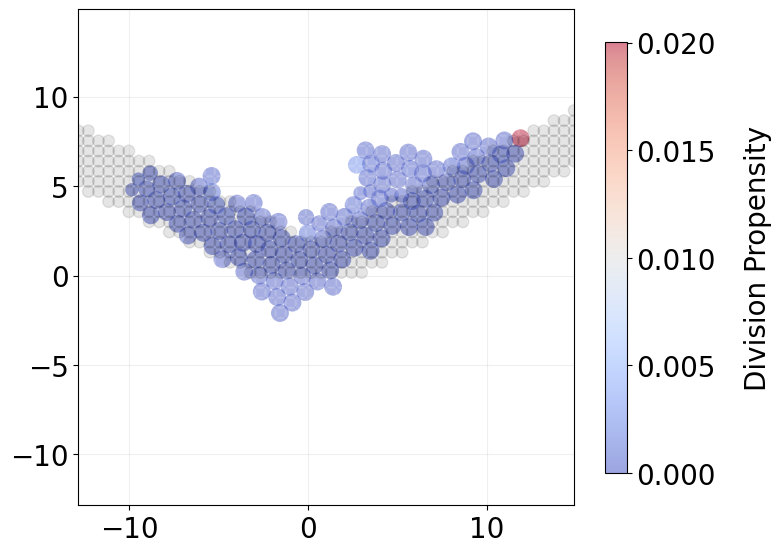

In [95]:
draw_circles_divrate(fstate, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

## Kill fraction (random)

In [109]:
KILL_RATE = .7
N_CELLS = int((fstate.celltype > 0).sum())
N_KILL = int(KILL_RATE * N_CELLS)

kill_state = kill_random(key, fstate, kill_rate=KILL_RATE)

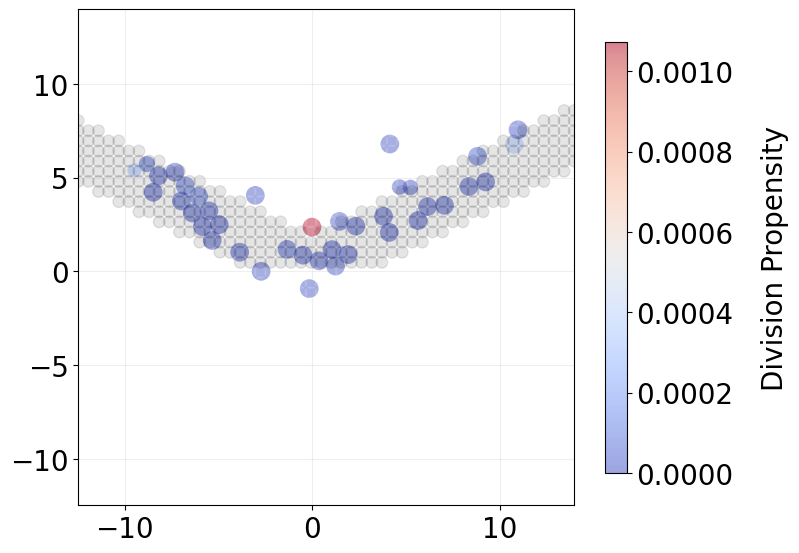

In [147]:
draw_circles_divrate(kill_state, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

In [113]:
# merge params dicts
all_params = eqx.combine(params_t[-1], params)

NCELLS_ADD = N_KILL

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
regen_state, _ = sim_trajectory(kill_state, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(regen_state)))

Final state metric:	135.02925


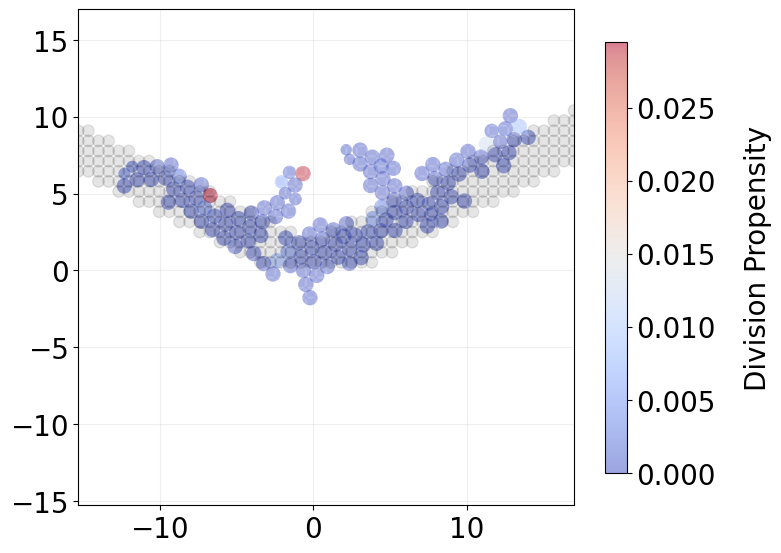

In [114]:
draw_circles_divrate(regen_state, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

### Kill rate vs. Recovery

In [158]:
kill_rates = np.linspace(.1,.9,7)
n_avg = 20

N_CELLS = int((fstate.celltype > 0).sum())
n_kills = (kill_rates * N_CELLS).astype(int)
kill_rates = n_kills / N_CELLS #recalculate actual kill rates

all_params = eqx.combine(params_t[-1], params)

log = {'kill_rates':kill_rates.tolist(), 'regen_metrics_avg':[], 'regen_metrics_std':[]}

for kr, nk in zip(kill_rates, n_kills):
    reps = []
    for i in tqdm(np.arange(n_avg), desc='kill rate: ' + str(kr)):

        key, subkey, subkey_reg = split(key, 3)

        kill_state = kill_random(subkey, fstate, kill_rate=kr)

        #forward pass - simulation
        sim_init, sim_step = simulation(fstep, all_params, fspace)
        regen_state, _ = sim_trajectory(kill_state, sim_init, sim_step, ncells_add=nk, key=subkey_reg)

        reps += [float(METRIC_FN(regen_state))]

    reps = np.array(reps)
    log['regen_metrics_avg'] += [float(np.mean(reps))]
    log['regen_metrics_std'] += [float(np.std(reps))]

kill rate: 0.9: 100%|███████████████████████████| 20/20 [00:45<00:00,  2.25s/it]


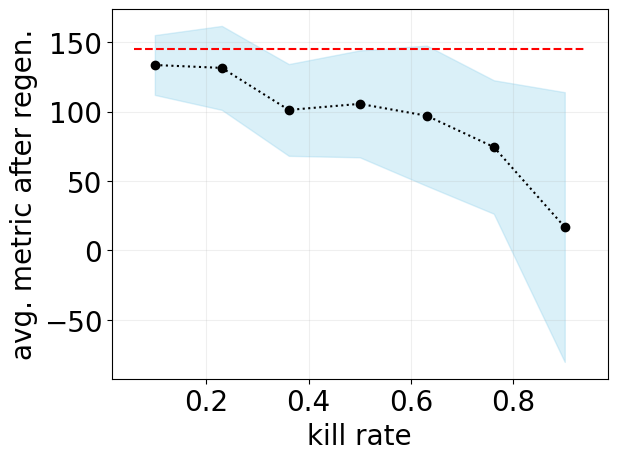

In [164]:
#plot results

#plt.errorbar(log['kill_rates'], log['regen_metrics_avg'], yerr=log['regen_metrics_std'], fmt='o-')
plt.plot(log['kill_rates'], log['regen_metrics_avg'], 'ko:')
plt.fill_between(log['kill_rates'], np.array(log['regen_metrics_avg']) - np.array(log['regen_metrics_std']), np.array(log['regen_metrics_avg']) + np.array(log['regen_metrics_std']), alpha=.3, color='skyblue')

plt.hlines(METRIC_FN(fstate), *plt.gca().get_xlim(), linestyles='dashed', color='r')

plt.xlabel('kill rate')
plt.ylabel('avg. metric after regen.')
plt.grid(alpha=.2)

## Kill below line

In [127]:
kill_state_line = kill_line(fstate)

N_KILL_LINE = int(fstate.celltype.shape[0]-kill_state_line.celltype.shape[0])

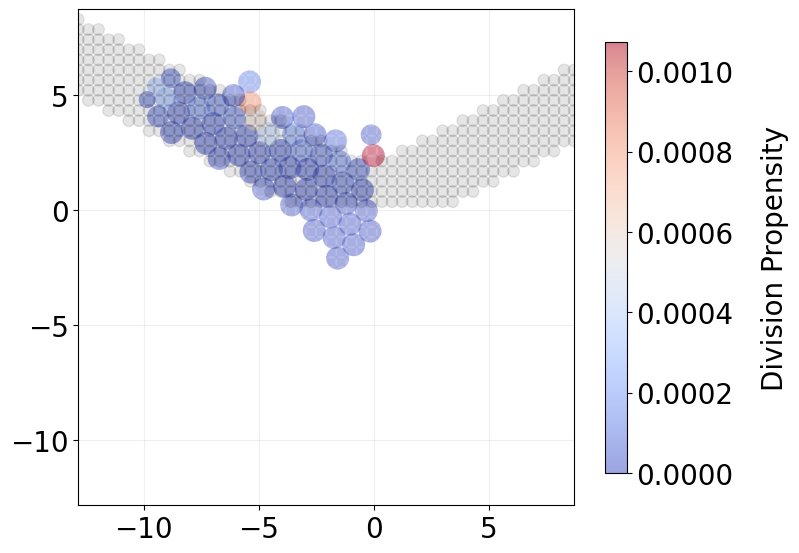

In [128]:
draw_circles_divrate(kill_state_line, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

In [145]:
# merge params dicts
all_params = eqx.combine(params_t[-1], params)

NCELLS_ADD = N_KILL_LINE

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
regen_state_line, _ = sim_trajectory(kill_state_line, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(regen_state_line)))

Final state metric:	-73.63049


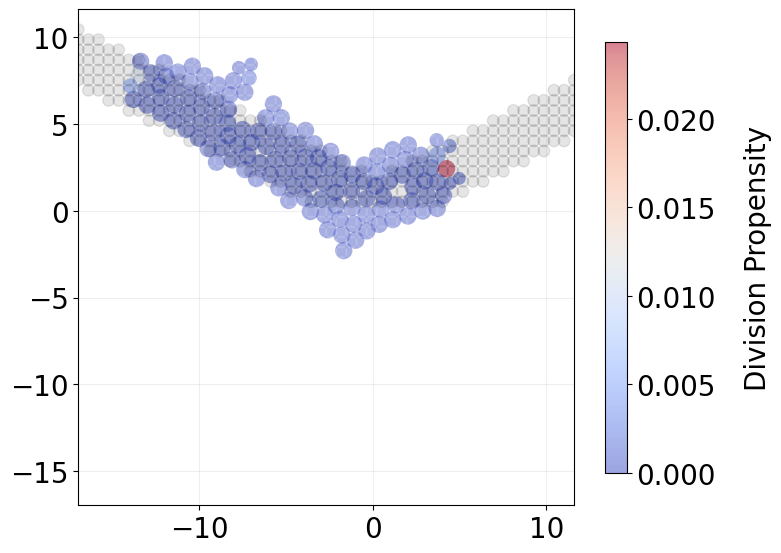

In [146]:
draw_circles_divrate(regen_state_line, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);